<center> 

# EN3160 Assignment 3
## Neural Networks

### Priyankan V. - 210498T
#### [GitHub/priyankan-v](https://github.com/priyankan-v/Assignment-3-on-Neural-Networks)
</center>

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import gc
import os
import time, copy

Question 1

In [9]:
# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# 2. Define Network Parameters
Din = 3 * 32 * 32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
std = 1e-5

# Initialize weights and biases
w = torch.randn(Din, K) * std # One layer: directly map input to output
b = torch.zeros(K)

# Hyperparameters
iterations = 20
lr = 2e-6 # Learning rate
lr_decay = 0.9 # Learning rate decay
reg = 0 # Regularization
loss_history = []

In [11]:
# 3. Training Loop
for t in range(iterations ):
    running_loss = 0.0
    for i , data in enumerate(trainloader , 0):
        # Get inputs and labels
        inputs , labels = data
        Ntr = inputs.shape[0] # Batch size
        x_train = inputs.view(Ntr, -1) # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels , K). float () # Convert labels to one=hot encoding
        
        # Forward pass
        y_pred = x_train.mm(w) + b # Output layer activation
        
        # Loss calculation (Mean Squared Error with regularization)
        loss = (1 / Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * torch.sum(w**2)
        loss_history.append(loss.item())
        running_loss += loss.item()
        
        # Backpropagation
        dy_pred = (2.0 / Ntr) * (y_pred - y_train_onehot)
        dw = x_train.t().mm(dy_pred) + reg * w
        db = dy_pred.sum(dim=0)
        
        # Parameter update
        w -= lr * dw
        b -= lr * db
        
    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t +1}/{ iterations}, Loss:{ running_loss/len ( trainloader )} " )
    
    # Learning rate decay
    lr *= lr_decay

Epoch 1/20, Loss:0.9769403639435769 
Epoch 2/20, Loss:0.9498276161551475 
Epoch 3/20, Loss:0.936075426876545 
Epoch 4/20, Loss:0.9275192919373513 
Epoch 5/20, Loss:0.9215804135203362 
Epoch 6/20, Loss:0.9171763652563095 
Epoch 7/20, Loss:0.9137656471729279 
Epoch 8/20, Loss:0.9110400506854057 
Epoch 9/20, Loss:0.9088120693564415 
Epoch 10/20, Loss:0.9069605846405029 
Epoch 11/20, Loss:0.9054009646773339 
Epoch 12/20, Loss:0.9040743553638458 
Epoch 13/20, Loss:0.9029364304542542 
Epoch 14/20, Loss:0.9019536101818084 
Epoch 15/20, Loss:0.9011001932621002 
Epoch 16/20, Loss:0.9003556609153748 
Epoch 17/20, Loss:0.8997033239603043 
Epoch 18/20, Loss:0.8991301010251045 
Epoch 19/20, Loss:0.8986248946785926 
Epoch 20/20, Loss:0.8981784778237343 


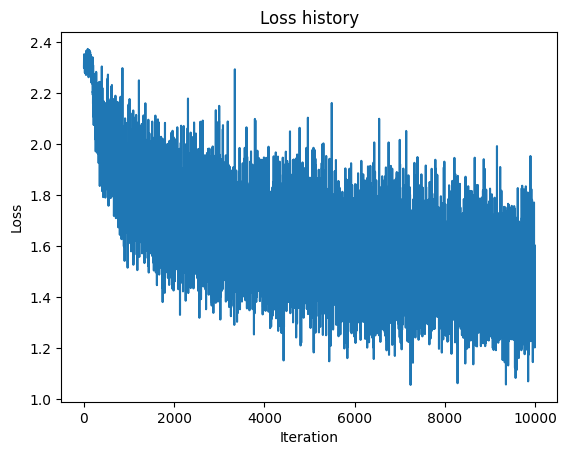

In [64]:
# 4. Plotting the Loss History
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

In [13]:
# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch .no_grad ():
    for data in trainloader :
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        y_train_onehot = nn.functional.one_hot(labels, K).float()
        
        # Forward pass
        y_train_pred = x_train.mm(w) + b
        predicted_train = torch.argmax(y_train_pred ,dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        
train_acc = 100 * correct_train / total_train
print(f"Training accuracy :{ train_acc :.2f}%")

Training accuracy :32.21%


In [14]:
# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0

with torch .no_grad ():
    for data in testloader :
        inputs , labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        y_test_onehot = nn. functional .one_hot(labels , K). float ()
        
        # Forward pass
        y_test_pred = x_test .mm(w) + b
        predicted_test = torch .argmax(y_test_pred , dim=1)
        total_test += labels . size (0)
        correct_test += (predicted_test == labels ).sum(). item()
        
test_acc = 100 * correct_test / total_test
print(f"Test accuracy : {test_acc : .2f}%")

Test accuracy :  32.46%


(a) Adding a middle layer with 100 nodes and a sigmoid activation

In [18]:
# Define network parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100            # Hidden layer size
K = 10             # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases for 2-layer network
w1 = torch.randn(Din, H) * std  # Weights for input to hidden layer
b1 = torch.zeros(H)             # Bias for hidden layer
w2 = torch.randn(H, K) * std    # Weights for hidden to output layer
b2 = torch.zeros(K)             # Bias for output layer

In [19]:
# Hyperparameters
iterations = 20
lr = 2e-6
lr_decay = 0.9
reg = 0
loss_history = []

# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        y_train_onehot = nn.functional.one_hot(labels, K).float()

        # Forward pass
        h = x_train.mm(w1) + b1  # Middle layer activation
        h = torch.sigmoid(h)     # Sigmoid activation
        y_pred = h.mm(w2) + b2   # Output layer activation

        # Loss calculation
        loss = (1 / Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + \
               reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = (2.0 / Ntr) * (y_pred - y_train_onehot)
        dh = dy_pred.mm(w2.t()) * h * (1 - h)  # Backprop through sigmoid

        # Gradient calculation
        dw2 = h.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)
        dw1 = x_train.t().mm(dh) + reg * w1
        db1 = dh.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1}/{iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay


Epoch 1/20, Loss: 0.9902909774184226
Epoch 2/20, Loss: 0.9740747457742691
Epoch 3/20, Loss: 0.9619878852367401
Epoch 4/20, Loss: 0.9528067809343338
Epoch 5/20, Loss: 0.9457132986187935
Epoch 6/20, Loss: 0.9401482046842575
Epoch 7/20, Loss: 0.9357217860817909
Epoch 8/20, Loss: 0.9321571255326271
Epoch 9/20, Loss: 0.9292543317079545
Epoch 10/20, Loss: 0.9268667241334915
Epoch 11/20, Loss: 0.9248850389122963
Epoch 12/20, Loss: 0.9232269296646118
Epoch 13/20, Loss: 0.9218293387293816
Epoch 14/20, Loss: 0.92064361256361
Epoch 15/20, Loss: 0.9196316952109337
Epoch 16/20, Loss: 0.9187634772658348
Epoch 17/20, Loss: 0.9180149767398834
Epoch 18/20, Loss: 0.9173668991923333
Epoch 19/20, Loss: 0.9168035930991173
Epoch 20/20, Loss: 0.9163123187422753


In [20]:
#Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        hidden_layer = torch.sigmoid(x_train.mm(w1) + b1)
        y_train_pred = hidden_layer.mm(w2) + b2
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    print(f"Training accuracy: {train_acc:.2f}%")

Training accuracy: 10.00%


In [21]:
# Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        hidden_layer = torch.sigmoid(x_test.mm(w1) + b1)
        y_test_pred = hidden_layer.mm(w2) + b2
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 10.00%


(b) Use cross-entropy loss with 20 epochs

In [22]:
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w1 = torch.randn(Din, 100) * std  # First layer (input to middle)
b1 = torch.zeros(100)
w2 = torch.randn(100, K) * std  # Second layer (middle to output)
b2 = torch.zeros(K)

# Hyperparameters
iterations = 20
lr = 0.1  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 1e-5  # Regularization
loss_history = []

# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)

        # Forward pass
        hidden = torch.sigmoid(x_train.mm(w1) + b1)  # Middle layer with sigmoid activation
        y_pred = hidden.mm(w2) + b2  # Output layer (no activation here)

        # Loss calculation (Cross-Entropy Loss with manual softmax)
        softmax = torch.softmax(y_pred, dim=1)
        loss = -torch.sum(torch.log(softmax[range(Ntr), labels])) / Ntr
        loss += reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))  # Add regularization
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = torch.zeros_like(y_pred)
        dy_pred.scatter_(1, labels.unsqueeze(1), -1)  # Set gradient for correct class
        dy_pred += softmax  # Add probability of each class
        dy_pred /= Ntr  # Scale by batch size

        # Compute gradients for w2 and b2
        dw2 = hidden.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)

        # Compute gradients for w1 and b1
        dh = dy_pred.mm(w2.t())  # Propagate gradient back to hidden layer
        dh_sigmoid = hidden * (1 - hidden) * dh  # Apply derivative of sigmoid function
        dw1 = x_train.t().mm(dh_sigmoid) + reg * w1
        db1 = dh_sigmoid.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1}/{iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1/20, Loss: 2.0351491520404816
Epoch 2/20, Loss: 1.7819785214662551
Epoch 3/20, Loss: 1.7021234774589538
Epoch 4/20, Loss: 1.6520682437419891
Epoch 5/20, Loss: 1.6119828037023545
Epoch 6/20, Loss: 1.5769522867202759
Epoch 7/20, Loss: 1.5459378714561463
Epoch 8/20, Loss: 1.5191485137939453
Epoch 9/20, Loss: 1.4945442020893096
Epoch 10/20, Loss: 1.4728810217380524
Epoch 11/20, Loss: 1.453302527666092
Epoch 12/20, Loss: 1.4361127068996429
Epoch 13/20, Loss: 1.4212569115161895
Epoch 14/20, Loss: 1.4063568997383118
Epoch 15/20, Loss: 1.393188391327858
Epoch 16/20, Loss: 1.381994554400444
Epoch 17/20, Loss: 1.371423847734928
Epoch 18/20, Loss: 1.3628829238414764
Epoch 19/20, Loss: 1.3538918547034264
Epoch 20/20, Loss: 1.346461384177208


In [23]:
# Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)

        # Forward pass
        hidden = torch.sigmoid(x_train.mm(w1) + b1)
        y_train_pred = hidden.mm(w2) + b2
        predicted_train = torch.argmax(y_train_pred, dim=1)
        
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    print(f"Training accuracy: {train_acc:.2f}%")

Training accuracy: 54.49%


In [24]:
# Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)

        # Forward pass
        hidden = torch.sigmoid(x_test.mm(w1) + b1)
        y_test_pred = hidden.mm(w2) + b2
        predicted_test = torch.argmax(y_test_pred, dim=1)
        
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 49.13%


(c) Run the network for 10 epochs nad report the training and test accuracies.

In [25]:
# Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w1 = torch.randn(Din, 100) * std  # First layer (input to middle)
b1 = torch.zeros(100)
w2 = torch.randn(100, K) * std  # Second layer (middle to output)
b2 = torch.zeros(K)

# Hyperparameters
iterations = 10
lr = 0.1  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 1e-5  # Regularization
loss_history = []

# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)

        # Forward pass
        hidden = torch.sigmoid(x_train.mm(w1) + b1)  # Middle layer with sigmoid activation
        y_pred = hidden.mm(w2) + b2  # Output layer (no activation here)

        # Loss calculation (Cross-Entropy Loss with manual softmax)
        softmax = torch.softmax(y_pred, dim=1)
        loss = -torch.sum(torch.log(softmax[range(Ntr), labels])) / Ntr
        loss += reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))  # Add regularization
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = torch.zeros_like(y_pred)
        dy_pred.scatter_(1, labels.unsqueeze(1), -1)  # Set gradient for correct class
        dy_pred += softmax  # Add probability of each class
        dy_pred /= Ntr  # Scale by batch size

        # Compute gradients for w2 and b2
        dw2 = hidden.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)

        # Compute gradients for w1 and b1
        dh = dy_pred.mm(w2.t())  # Propagate gradient back to hidden layer
        dh_sigmoid = hidden * (1 - hidden) * dh  # Apply derivative of sigmoid function
        dw1 = x_train.t().mm(dh_sigmoid) + reg * w1
        db1 = dh_sigmoid.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1}/{iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1/10, Loss: 2.034463143825531
Epoch 2/10, Loss: 1.7833832564353942
Epoch 3/10, Loss: 1.698010733962059
Epoch 4/10, Loss: 1.6487443498373031
Epoch 5/10, Loss: 1.6081298079490662
Epoch 6/10, Loss: 1.5748026914596558
Epoch 7/10, Loss: 1.5461193318367004
Epoch 8/10, Loss: 1.5207550961971283
Epoch 9/10, Loss: 1.4975387822389603
Epoch 10/10, Loss: 1.4757153260707856


In [26]:
# Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)

        # Forward pass
        hidden = torch.sigmoid(x_train.mm(w1) + b1)
        y_train_pred = hidden.mm(w2) + b2
        predicted_train = torch.argmax(y_train_pred, dim=1)

        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

Training accuracy: 49.83%


In [27]:
# Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)

        # Forward pass
        hidden = torch.sigmoid(x_test.mm(w1) + b1)
        y_test_pred = hidden.mm(w2) + b2
        predicted_test = torch.argmax(y_test_pred, dim=1)

        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 46.77%


Although the training loss decreases, the relatively low training accuracy (49.83%) and test accuracy (46.77%) suggest that the model has difficulty generalizing. This could be due to the model's simplicity and shallow architecture. Enhancing the model by adding more layers or employing more advanced architectures could potentially improve its performance.

Question 2 : LeNet5

In [65]:
batch_size = 32
train_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader_mnist = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False)
class_labels = tuple(str(i) for i in range(10))

In [66]:
def train(model:nn.Module,
          trainloader:torch.utils.data.DataLoader,
          testloader:torch.utils.data.DataLoader,
          iterations:int,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          device: torch.device) -> tuple:
    train_accuracy_hist = [ ]
    test_accuracy_hist = [ ]
    train_loss_hist = [ ]
    test_loss_hist = [ ]
    for t in range(iterations):
        model.train()
        accuracy = 0
        running_loss = 0.0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            x_train, y_train = inputs.to(device), labels.to(device)
            y_pred = model(x_train)
            loss_val = loss_fn(y_pred, y_train)
            running_loss += loss_val.item()
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            _, predicted = torch.max(y_pred, 1)
            accuracy += (predicted == y_train).sum().item()
        train_accuracy_hist.append(accuracy / len(trainloader.dataset))
        train_loss_hist.append(running_loss / len(trainloader))
        model.eval()
        with torch.inference_mode():
            accuracy = 0
            running_loss = 0.0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                x_test, y_test = inputs.to(device), labels.to(device)
                y_pred = model(x_test)
                loss_val = loss_fn(y_pred, y_test)
                running_loss += loss_val.item()
                _, predicted = torch.max(y_pred, 1)
                accuracy += (predicted == y_test).sum().item()
            test_accuracy_hist.append(accuracy / len(testloader.dataset))
            test_loss_hist.append(running_loss / len(testloader))
        print(f"Epoch {t + 1} / {iterations}, Train Loss: {train_loss_hist[-1]}, Test Loss: {test_loss_hist[-1]}, Train Accuracy: {train_accuracy_hist[-1]}, Test Accuracy: {test_accuracy_hist[-1]}")
    return train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist

In [67]:
# Define the LeNet-5 Architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Define the convolutional layers
        self.layer1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.layer2 = nn.Conv2d(6, 16, kernel_size=5)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply convolutions, activations, and pooling
        x = torch.relu(self.layer1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.layer2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        # Flatten before fully connected layers
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [68]:
# Load and Preprocess the Data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

batch_size = 64

# Prepare training and testing datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=data_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=data_transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

In [69]:
# Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [70]:
# Train the Model
num_epochs = 10
train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        epoch_loss += loss.item() * images.size(0)
        _, predicted_classes = torch.max(predictions, 1)
        total_train += labels.size(0)
        correct_train += (predicted_classes == labels).sum().item()

    train_loss = epoch_loss / total_train
    train_accuracy = 100 * correct_train / total_train
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # Validate the Model
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_classes = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted_classes == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracy_list.append(test_accuracy)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.4135, Train Accuracy: 86.65%, Test Accuracy: 97.57%
Epoch [2/10], Train Loss: 0.0687, Train Accuracy: 97.77%, Test Accuracy: 98.42%
Epoch [3/10], Train Loss: 0.0442, Train Accuracy: 98.60%, Test Accuracy: 98.80%
Epoch [4/10], Train Loss: 0.0348, Train Accuracy: 98.94%, Test Accuracy: 98.69%
Epoch [5/10], Train Loss: 0.0292, Train Accuracy: 99.05%, Test Accuracy: 98.72%
Epoch [6/10], Train Loss: 0.0238, Train Accuracy: 99.22%, Test Accuracy: 98.98%
Epoch [7/10], Train Loss: 0.0186, Train Accuracy: 99.42%, Test Accuracy: 98.87%
Epoch [8/10], Train Loss: 0.0177, Train Accuracy: 99.42%, Test Accuracy: 98.80%
Epoch [9/10], Train Loss: 0.0141, Train Accuracy: 99.56%, Test Accuracy: 99.04%
Epoch [10/10], Train Loss: 0.0123, Train Accuracy: 99.63%, Test Accuracy: 99.07%


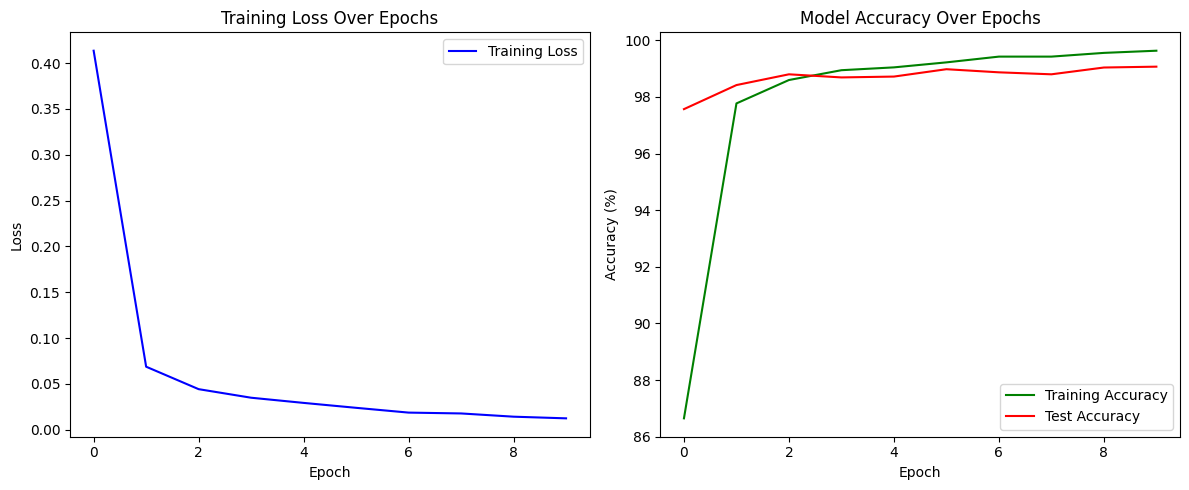

In [71]:
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot the training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Training Accuracy', color='green')
plt.plot(test_accuracy_list, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
# Overall training accuracy
overall_train_accuracy = train_accuracy_list[-1]

# Overall test accuracy
overall_test_accuracy = test_accuracy_list[-1]

# Print training and test accuracies
print(f"Training accuracy: {overall_train_accuracy:.2f}%")
print(f"Test accuracy: {overall_test_accuracy:.2f}%")

Training accuracy: 99.63%
Test accuracy: 99.07%


The LeNet-5 architecture demonstrates outstanding performance on the MNIST dataset, achieving a training accuracy of 99.63% and a test accuracy of 99.07%. This indicates that the model is highly effective for this particular task, reaching impressive accuracy levels within just 10 training epochs.

Question 3 : Using ResNet18

In [73]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [74]:
# Load a pre-trained ResNet-18 model
model_base = models.resnet18(pretrained=True)

# Define data transformations for training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Define paths for datasets
data_dir = './data/hymenoptera'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [75]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            epoch_loss, epoch_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)
                epoch_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            avg_loss = epoch_loss / dataset_sizes[phase]
            avg_accuracy = epoch_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {avg_loss:.4f} Accuracy: {avg_accuracy:.4f}')
            
            if phase == 'val' and avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_weights = copy.deepcopy(model.state_dict())

        print()

    total_time = time.time() - start_time
    print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')
    
    model.load_state_dict(best_weights)
    return model

(a) Fine tuning

In [76]:
model_finetune = models.resnet18(pretrained=True)
num_features = model_finetune.fc.in_features
model_finetune.fc = nn.Linear(num_features, 2)
model_finetune = model_finetune.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_finetune.parameters(), lr=0.001, momentum=0.9)
lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the fine-tuned model
model_finetune = train_model(model_finetune, loss_function, optimizer_ft, lr_scheduler_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6127 Accuracy: 0.6680
val Loss: 0.2371 Accuracy: 0.9085

Epoch 1/19
----------
train Loss: 0.6451 Accuracy: 0.7418
val Loss: 0.2578 Accuracy: 0.8954

Epoch 2/19
----------
train Loss: 0.5399 Accuracy: 0.7541
val Loss: 0.2723 Accuracy: 0.9020

Epoch 3/19
----------
train Loss: 0.5119 Accuracy: 0.7828
val Loss: 0.2091 Accuracy: 0.9216

Epoch 4/19
----------
train Loss: 0.4083 Accuracy: 0.8238
val Loss: 0.3029 Accuracy: 0.8954

Epoch 5/19
----------
train Loss: 0.4716 Accuracy: 0.7787
val Loss: 0.4080 Accuracy: 0.8693

Epoch 6/19
----------
train Loss: 0.4855 Accuracy: 0.7910
val Loss: 0.4671 Accuracy: 0.8170

Epoch 7/19
----------
train Loss: 0.4061 Accuracy: 0.8811
val Loss: 0.1799 Accuracy: 0.9412

Epoch 8/19
----------
train Loss: 0.3889 Accuracy: 0.8402
val Loss: 0.1659 Accuracy: 0.9477

Epoch 9/19
----------
train Loss: 0.2645 Accuracy: 0.8811
val Loss: 0.1864 Accuracy: 0.9477

Epoch 10/19
----------
train Loss: 0.2605 Accuracy: 0.9180
val Loss: 0

The model demonstrates strong performance, as evidenced by the consistent decrease in both training and validation losses, alongside an increase in training and validation accuracies with each epoch. By the end of 20 epochs, the model successfully achieved best validation accuracy of 95.42%.

(b) Network as feature extractor

In [77]:
model_extracted = models.resnet18(pretrained=True)
for param in model_extracted.parameters():
    param.requires_grad = False

model_extracted.fc = nn.Linear(num_features, 2)
model_extracted = model_extracted.to(device)

optimizer_extracted = optim.SGD(model_extracted.fc.parameters(), lr=0.001, momentum=0.9)
lr_scheduler_extracted = lr_scheduler.StepLR(optimizer_extracted, step_size=7, gamma=0.1)

# Train with feature extraction
model_extracted = train_model(model_extracted, loss_function, optimizer_extracted, lr_scheduler_extracted, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5500 Accuracy: 0.6721
val Loss: 0.1943 Accuracy: 0.9412

Epoch 1/19
----------
train Loss: 0.4685 Accuracy: 0.8033
val Loss: 0.1771 Accuracy: 0.9477

Epoch 2/19
----------
train Loss: 0.4979 Accuracy: 0.7705
val Loss: 0.2027 Accuracy: 0.9281

Epoch 3/19
----------
train Loss: 0.4486 Accuracy: 0.7705
val Loss: 0.1764 Accuracy: 0.9346

Epoch 4/19
----------
train Loss: 0.5057 Accuracy: 0.7541
val Loss: 0.1987 Accuracy: 0.9346

Epoch 5/19
----------
train Loss: 0.5764 Accuracy: 0.7828
val Loss: 0.2860 Accuracy: 0.8954

Epoch 6/19
----------
train Loss: 0.6626 Accuracy: 0.7336
val Loss: 0.3303 Accuracy: 0.8889

Epoch 7/19
----------
train Loss: 0.3070 Accuracy: 0.8607
val Loss: 0.2108 Accuracy: 0.9346

Epoch 8/19
----------
train Loss: 0.3545 Accuracy: 0.8361
val Loss: 0.2016 Accuracy: 0.9281

Epoch 9/19
----------
train Loss: 0.4100 Accuracy: 0.8197
val Loss: 0.2083 Accuracy: 0.9216

Epoch 10/19
----------
train Loss: 0.2914 Accuracy: 0.8852
val Loss: 0

Using the model as a feature extractor also yields impressive results. After 20 epochs, it achieved a validation accuracy of 94.77%, matching the performance obtained through fine-tuning.